# Exercise with Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
# read the data and set "datetime" as the index
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [3]:
# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
# create "hour" as its own feature
bikes['hour'] = bikes.index.hour

In [5]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,4


In [6]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

## Task 1

Run these two `groupby` statements and figure out what they tell you about the data.

In [7]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [8]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

## Task 2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

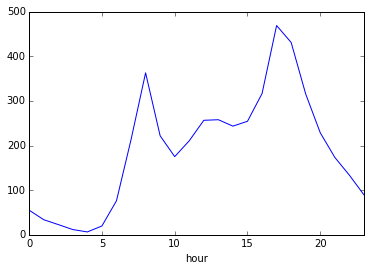

In [9]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

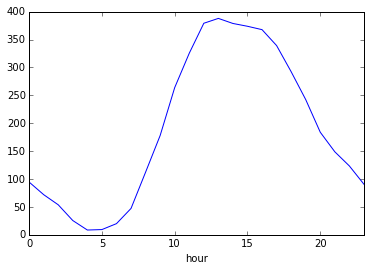

In [10]:
# hourly rental trend for "workingday=0"
bikes[bikes.workingday==0].groupby('hour').total.mean().plot()

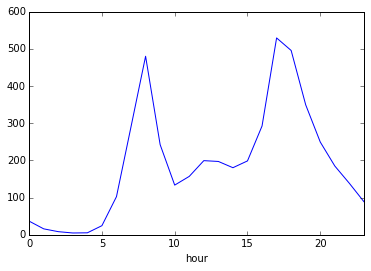

In [11]:
# hourly rental trend for "workingday=1"
bikes[bikes.workingday==1].groupby('hour').total.mean().plot()

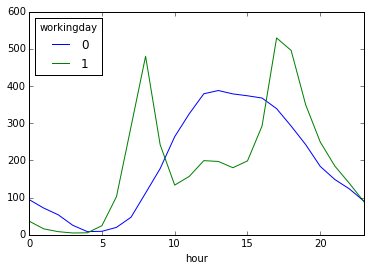

In [12]:
# combine the two plots
bikes.groupby(['hour', 'workingday']).total.mean().unstack().plot()

## Task 3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

In [13]:
# create X and y
feature_cols = ['hour', 'workingday']
X = bikes[feature_cols]
y = bikes.total

In [14]:
# fit a linear regression model and print coefficients
linreg = LinearRegression()
linreg.fit(X, y)
linreg.coef_

array([ 10.49206282,   4.07248627])

## Task 4

Use 10-fold cross-validation to calculate the RMSE for the linear regression model.

In [15]:
# save the 10 MSE scores output by cross_val_score
scores = cross_val_score(linreg, X, y, cv=10, scoring='mean_squared_error')

In [16]:
# convert MSE to RMSE, and then calculate the mean of the 10 RMSE scores
np.mean(np.sqrt(-scores))

165.22328668912968

## Task 5

Use 10-fold cross-validation to evaluate a decision tree model with those same features (fit to any "max_depth" you choose).

In [17]:
# evaluate a decision tree model with "max_depth=7"
treereg = DecisionTreeRegressor(max_depth=7, random_state=1)
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

107.64196789476493

## Task 6

Fit a decision tree model to the entire dataset using "max_depth=3", and create a tree diagram using Graphviz. Then, figure out what each leaf represents. What did the decision tree learn that a linear regression model could not learn?

In [18]:
# fit a decision tree model with "max_depth=3"
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

In [19]:
# create a Graphviz file
export_graphviz(treereg, out_file='tree_bikeshare.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_bikeshare.dot -o tree_bikeshare.png

![Tree for bikeshare data](images/tree_bikeshare.png)